# SMAC Counterfactual Analysis Demo

This notebook demonstrates running counterfactual analysis on SMAC with a random policy.

In [6]:
import sys
import os

In [7]:
# Get the absolute path to the agents folder
examples_path = os.path.abspath('../')
smac_agents_path = os.path.abspath('../../playing-with-smac/smac/agents')
ppo_path = os.path.join(smac_agents_path, 'PPO_one_action')

sys.path.insert(0, smac_agents_path)  # For utils
sys.path.insert(0, ppo_path)          # For random_policy
sys.path.insert(0, examples_path)     # For utils
sys.path.insert(0, '/home/ad.msoe.edu/manchadoa/UR-RL/counterfactual-reasoning/src')
os.environ['SC2PATH'] = '/home/ad.msoe.edu/manchadoa/UR-RL/playing-with-smac/StarCraftII'



In [8]:
import logging
import absl.logging
from contextlib import contextmanager
import matplotlib.pyplot as plt
from counterfactual_rl.analysis import MultiDiscreteCounterfactualAnalyzer
from counterfactual_rl.visualization.smac_plots import SmacConsequencePlotter
from utils import get_valid_actions


print(f"Added: {smac_agents_path}")
print(f"Added: {ppo_path}")

Added: /home/ad.msoe.edu/manchadoa/UR-RL/playing-with-smac/smac/agents
Added: /home/ad.msoe.edu/manchadoa/UR-RL/playing-with-smac/smac/agents/PPO_one_action


## 1. Setup SMAC Environment

In [9]:
from smac.env import StarCraft2Env
from counterfactual_rl.environments.smac import CentralizedSmacWrapper, SmacStateManager

# Create SMAC environment (3m = 3 Marines vs 3 Marines)
smac_env = StarCraft2Env(map_name="3m", debug=True)
# Wrap it for centralized control
env = CentralizedSmacWrapper(smac_env, use_state=True)

# Get environment info
print(f"Agents: {env.n_agents}")
print(f"Actions per agent: {env.n_actions_per_agent}")
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

Version: B55958 (SC2.3.16)
Build: Jul 31 2017 13:19:41
Command Line: '"/home/ad.msoe.edu/manchadoa/UR-RL/playing-with-smac/StarCraftII/Versions/Base55958/SC2_x64" -listen 127.0.0.1 -port 35403 -dataDir /home/ad.msoe.edu/manchadoa/UR-RL/playing-with-smac/StarCraftII/ -tempDir /tmp/sc-_pr9x1i1/'
Starting up...
Startup Phase 1 complete
Startup Phase 2 complete
Creating stub renderer...
Listening on: 127.0.0.1:35403 (35403)
Startup Phase 3 complete. Ready for commands.
Requesting to join a single player game
Configuring interface options
Configure: raw interface enabled
Configure: feature layer interface disabled
Configure: score interface disabled
Configure: render interface disabled
Entering load game phase.
Launching next game.
Next launch phase started: 2
Next launch phase started: 3
Next launch phase started: 4
Next launch phase started: 5
Next launch phase started: 6
Next launch phase started: 7
Next launch phase started: 8


Agents: 3
Actions per agent: 9
Action space: MultiDiscrete([9 9 9])
Observation space: Box(-inf, inf, (48,), float32)


Game has started.
Sending ResponseJoinGame


## 2. Create Random Policy

In [10]:
from random_policy import RandomPolicy

# Create random policy (uses raw SMAC env for action masking)
policy = RandomPolicy(env=smac_env)

print(f"Policy n_agents: {policy.n_agents}")
print(f"Policy n_actions: {policy.n_actions}")

Policy n_agents: 3
Policy n_actions: 9


## 3. Setup Counterfactual Analyzer

In [11]:
# Create analyzer
analyzer = MultiDiscreteCounterfactualAnalyzer(
    model=policy,
    env=env,
    state_manager=SmacStateManager,
    get_valid_actions_fn=lambda: get_valid_actions(smac_env),
    get_action_probs_fn=None,  # Uniform probability for random policy
    n_agents=policy.n_agents,
    n_actions=policy.n_actions,
    horizon=10,
    n_rollouts=10,  # Keep low for demo
    top_k=2,
    deterministic=False,
    log_file="smac_counterfactual_analysis.log",
)


print("Analyzer created!")
print(f"Logging to: smac_counterfactual_analysis.log")

INFO:CounterfactualAnalyzer_132778643994480:================================================================================
INFO:CounterfactualAnalyzer_132778643994480:Counterfactual Analysis Started
INFO:CounterfactualAnalyzer_132778643994480:Configuration: n_agents=3, n_actions=9
INFO:CounterfactualAnalyzer_132778643994480:Parameters: horizon=10, n_rollouts=10, top_k=2
INFO:CounterfactualAnalyzer_132778643994480:Gamma=0.99, Deterministic=False
INFO:CounterfactualAnalyzer_132778643994480:================================================================================


Analyzer created!
Logging to: smac_counterfactual_analysis.log


## 4. Run Counterfactual Analysis

In [12]:
import numpy as np

In [13]:
avail_actions_all = np.array([[0, 1, 1, 1, 1, 1, 0, 0, 0], [0, 1, 1, 1, 1, 1, 0, 0, 0], [0, 1, 1, 1, 1, 1, 0, 0, 0]])

print(avail_actions_all)
available_actions = [np.where(agent_avail_actions == 1)[0].tolist() for agent_avail_actions in avail_actions_all]

print(available_actions)


[[0 1 1 1 1 1 0 0 0]
 [0 1 1 1 1 1 0 0 0]
 [0 1 1 1 1 1 0 0 0]]
[[1, 2, 3, 4, 5], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5]]


In [14]:
# Evaluate a single episode
print("Running counterfactual analysis...")

records = analyzer.evaluate_episode(max_steps=2, verbose=True)

print(f"\nCollected {len(records)} records")

Version: B55958 (SC2.3.16)
Build: Jul 31 2017 13:19:41
Command Line: '"/home/ad.msoe.edu/manchadoa/UR-RL/playing-with-smac/StarCraftII/Versions/Base55958/SC2_x64" -listen 127.0.0.1 -port 34725 -dataDir /home/ad.msoe.edu/manchadoa/UR-RL/playing-with-smac/StarCraftII/ -tempDir /tmp/sc-e6sv4j0p/'
Starting up...
Startup Phase 1 complete


Running counterfactual analysis...


Startup Phase 2 complete
Creating stub renderer...
Listening on: 127.0.0.1:34725 (34725)
Startup Phase 3 complete. Ready for commands.
RequestQuit command received.
unable to parse websocket frame.
Closing Application...
Requesting to join a single player game
Configuring interface options
Configure: raw interface enabled
Configure: feature layer interface disabled
Configure: score interface disabled
Configure: render interface disabled
Entering load game phase.
Launching next game.
Next launch phase started: 2
Next launch phase started: 3
Next launch phase started: 4
Next launch phase started: 5
Next launch phase started: 6
Next launch phase started: 7
Next launch phase started: 8
Game has started.
Sending ResponseJoinGame
INFO:CounterfactualAnalyzer_132778643994480:
INFO:CounterfactualAnalyzer_132778643994480:Starting Episode Evaluation (max_steps=2)
INFO:CounterfactualAnalyzer_132778643994480:================================================================================
Episode st


Collected 2 records


## 5. Analyze Results

In [16]:
# Show consequence scores
if records:
    scores = [r.kl_score for r in records]
    print(f"Mean consequence score: {np.mean(scores):.4f}")
    print(f"Max consequence score: {np.max(scores):.4f}")
    print(f"Min consequence score: {np.min(scores):.4f}")
    
    # Show most consequential step
    most_consequential = max(records, key=lambda r: r.kl_score)
    print(f"\nMost consequential step:")
    print(f"  Action: {most_consequential.action}")
    print(f"  Score: {most_consequential.kl_score:.4f}")

Mean consequence score: 2.0836
Max consequence score: 3.9069
Min consequence score: 0.2604

Most consequential step:
  Action: (np.int64(5), np.int64(1), np.int64(1))
  Score: 3.9069


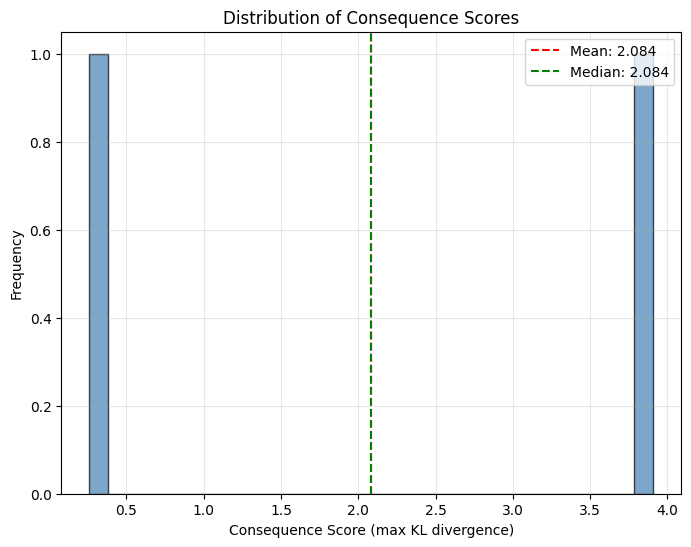

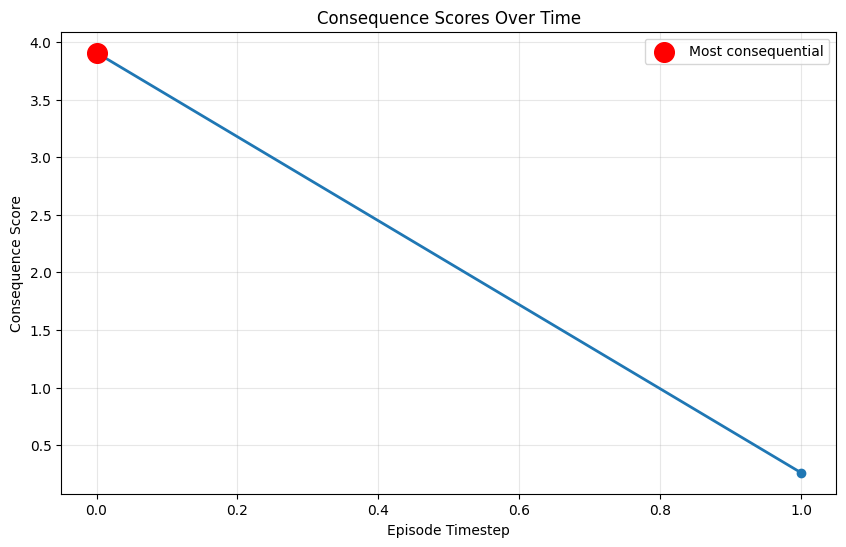

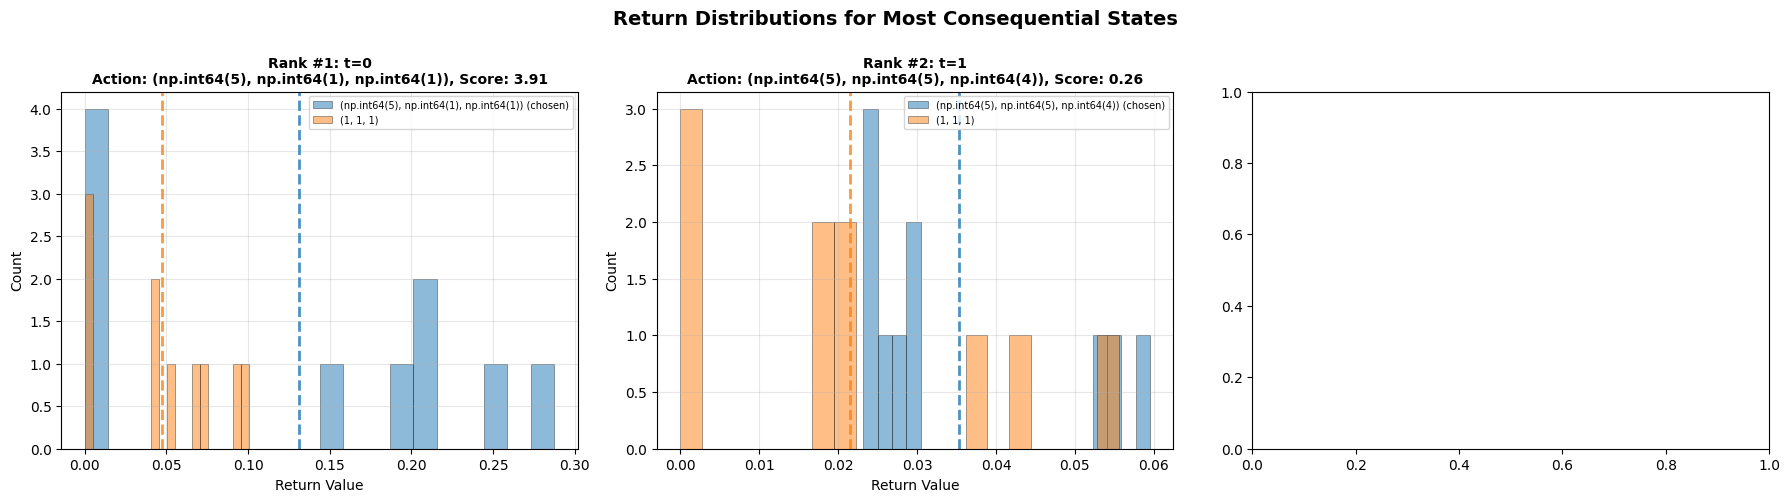


SMAC COUNTERFACTUAL ANALYSIS STATISTICS

Total timesteps analyzed: 2

Consequence Scores:
  Mean:   2.0836
  Median: 2.0836
  Std:    1.8233
  Min:    0.2604
  Max:    3.9069

Top-5 Most Consequential Moments:
  #1: Timestep 0, Action: (np.int64(5), np.int64(1), np.int64(1))
       KL Score: 3.9069
       Max KL vs (1, 1, 1): 3.9069
  #2: Timestep 1, Action: (np.int64(5), np.int64(5), np.int64(4))
       KL Score: 0.2604
       Max KL vs (1, 1, 1): 0.2604


In [17]:

plotter = SmacConsequencePlotter()

# Basic plots
plotter.plot_histogram(records)
plt.show()

plotter.plot_consequence_over_time(records)
plt.show()

plotter.plot_return_distributions(records, top_n=3)
plt.show()

# Statistics
plotter.print_statistics(records, top_n=5)

In [ ]:
# Cleanup
smac_env.close()
print("Environment closed.")

RequestQuit command received.
Closing Application...
unable to parse websocket frame.


Environment closed.
